In [12]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, models, transforms

import composer.functional as cf

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os


data_path = 'dataset/'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class_names = ['altar', 'apse', 'bell_tower', 'column', 'dome(inner)', 'dome(outer)', 'flying_buttress', 'gargoyle', 'stained_glass', 'vault']

In [13]:
# Transform
data_transforms = {
    'SingleTest':
        transforms.Compose([
            transforms.Resize(64),
            transforms.CenterCrop(64),
            transforms.ToTensor(),
            # from ResNet requirement
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
}

In [14]:
# Reconstruct Model
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))
model_ft = model_ft.to(device)

# Composer speed up
model_ft = cf.apply_blurpool(model_ft)
model_ft = cf.apply_squeeze_excite(model_ft)

# load weights
model_ft.load_state_dict(torch.load('model50.pth'))

<All keys matched successfully>

In [15]:
# image show function for visualization
def imshow(tensor, title):
    """
    Imshow for Tensor
    
    Param:
        inp: input tensor
        title: plot title
        
    output:
        matplotlib plot
    """
    # matplotlib imshow() requirement - (M, N, 3): an image with RGB values (0-1 float or 0-255 int).
    # take channel dim (2rd in (B,C,H,W)) into the last
    tensor = tensor.numpy().transpose((1, 2, 0))
    
    # from ResNet requirement
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    # de-normalized
    tensor = std * tensor + mean
    
    # ResNet requirement for image load in range [0,1]
    tensor = np.clip(tensor, 0, 1)
    
    plt.imshow(tensor)
    plt.title(title)
    
    # for plot update
    plt.pause(0.001)

dome(outer)


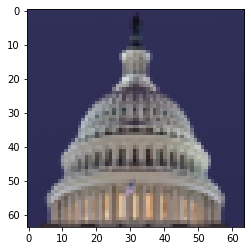

column


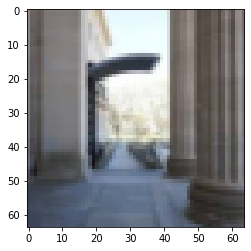

altar


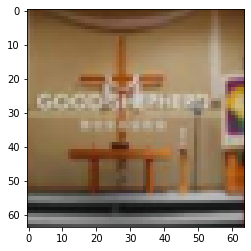

column


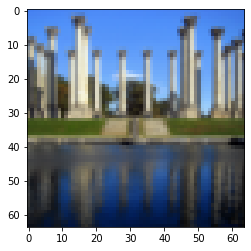

dome(inner)


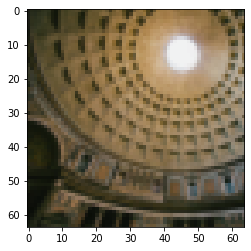

In [16]:
# Data load and basic info
# Data load
# Predict SingleTest directory images class
img_array = os.listdir(data_path + 'SingleTest')

for image_name in img_array:
    image = Image.open(data_path + 'SingleTest/' + image_name)
    tensor = data_transforms['SingleTest'](image)
    
    # add one dimension at the front (b,c,w,h)
    tensor = torch.unsqueeze(tensor, dim=0)

    model_ft.eval()
    
    with torch.no_grad():
        outputs = model_ft(tensor)
        _, preds = torch.max(outputs, 1)

        print(class_names[preds])
        imshow(torchvision.utils.make_grid(tensor),None)